### Race to the Bottom: A Comparison Between Gravity-Base Foundations and XXXL-Monopiles for U.S. Offshore Wind
This notebook processes WISDEM results for the IEA-15MW turbine using monopile and a gravity based foundation
- set the case: 'mono' or 'grav'
- specify rating: 15
- select depths: [20, 30, 40, 50, 60] 

In [260]:
import os

from pprint import pprint
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import numpy as np
import pandas as pd
import openmdao.api as om

from helper_functions import init_fig_axis, fig_format, save

import matplotlib.pyplot as plt
%matplotlib inline

SMALL = 10
MEDIUM = 12
LARGE = 16
plt.rc('font', size=SMALL)
plt.rc('axes', labelsize=MEDIUM)
plt.rc('axes', titlesize=LARGE)
plt.rc('xtick', labelsize=SMALL)
plt.rc('ytick', labelsize=SMALL)
plt.rc('legend', fontsize=MEDIUM)
plt.rc('figure', titlesize=LARGE)


### User Inputs and Directories

In [261]:
base = "mono" # or grav
name = "newtest_1" # suffix for plots/save files

save_plots = False

# Which machine ratings should we run [in MW]
ratings = [15] # [15, 20, 22, 25]

# Which depths should we run [in m]
depths  = [20, 30, 40, 50, 60] # [20, 30, 40, 50, 60] # [20, 30, 40, 50, 60]

ROOT = os.getcwd()
FIGDIR = os.path.join(ROOT, "_figures")
if not FIGDIR:
    os.mkdir(FIGDIR)

#fout_name = f'{base}_turb_output.npz'
fout_name = f'{base}tow_iea15_output.npz'
fom_name = f'log_opt_{base}_iea15.sql'


In [262]:
# Data containers to hold outputs from test matrix
m_tow = np.zeros((len(ratings), len(depths)))
c_tow = np.zeros(m_tow.shape)
m_mono = np.zeros(m_tow.shape)
c_mono = np.zeros(m_tow.shape)
l_mono = np.zeros(m_tow.shape)
m_trans = np.zeros(m_tow.shape)
c_trans = np.zeros(m_tow.shape)
m_struct = np.zeros(m_tow.shape)
rating_mat = np.zeros(m_tow.shape)
depth_mat = np.zeros(m_tow.shape)
#m_nacelle = np.zeros(m_tow.shape)
#c_turbine = np.zeros(m_tow.shape)

# When there is an array of data at every point, that could change size, use nested dictionaries instead of 3-D matrices
zpts = {}
diam = {}
thick = {}

# Loop over all ratings, and descend into folder
for ri, r in enumerate(ratings):
    os.chdir(f'{r}mw')

    # Initialize nested dictionaries
    zpts[r] = {}
    diam[r] = {}
    thick[r] = {}

    # Loop over all depths, and descend into folder
    for di, d in enumerate(depths):
        os.chdir(f'{d}m')

        # Store ratings and depths for easy plotting
        rating_mat[ri,di] = r
        depth_mat[ri,di] = d

        # Read archive of outputs from WISDEM run
        fout_path = os.path.join(f'outputs_{base}', fout_name)
        #try:
        out_archive = np.load(fout_path)

        #except FileExistsError:

        #    print(f"{fout_path} does not exist. ")

        # Store outputs into matrices.  List of available outputs can be found in the WISDEM documentation or in the csv- or xlsx-files
        m_tow[ri,di] = out_archive['towerse.tower_mass_kg']
        c_tow[ri,di] = out_archive['towerse.tower_cost_USD']
        m_mono[ri,di] = out_archive['fixedse.monopile_mass_kg']
        c_mono[ri,di] = out_archive['fixedse.monopile_cost_USD']
        l_mono[ri,di] = out_archive['fixedse.monopile_height_m']
        m_struct[ri,di] = out_archive['fixedse.structural_mass_kg']
        #m_nacelle[ri,di] = out_archive['orbit.nacelle_mass_t']
        #c_turbine[ri,di] = out_archive['orbit.turbine_capex_USD/kW']

        # Store the arrays for diameter, thickness, and z-points in the nested dictionary
        zpts[r][d] = np.r_[out_archive['monopile.ref_axis_m'][:,2], out_archive['tower.ref_axis_m'][:,2]]
        diam[r][d] = np.r_[out_archive['monopile.diameter_m'], out_archive['tower.diameter_m']]
        thick[r][d] = np.r_[out_archive['monopile.layer_thickness_m'][0,:], out_archive['tower.layer_thickness_m'][0,:]]

        os.chdir('..')
    os.chdir('..')

print(os.getcwd())

/Users/nriccobo/GitHub/WISDEM/examples/99_tower_gbf


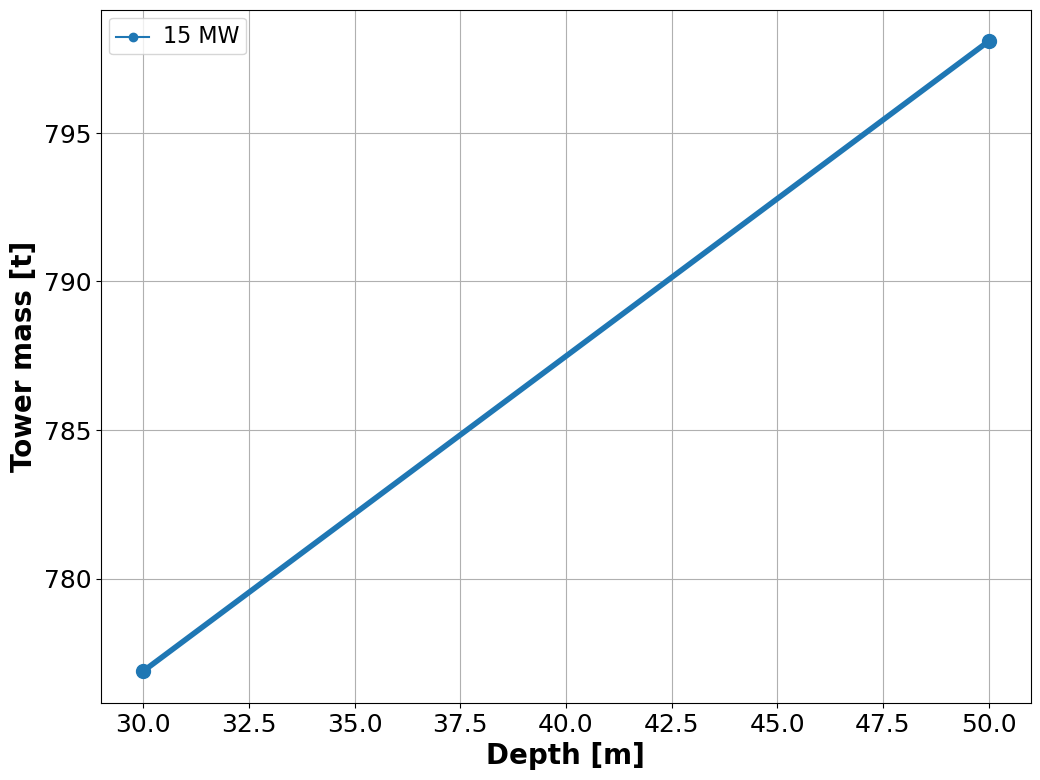

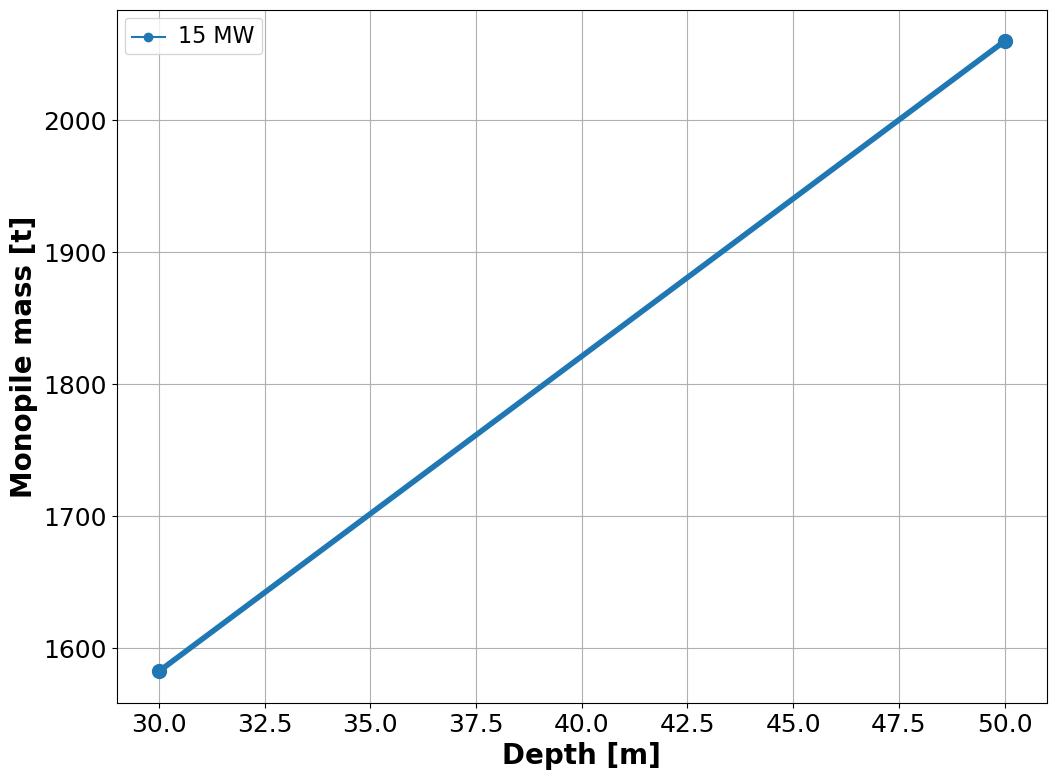

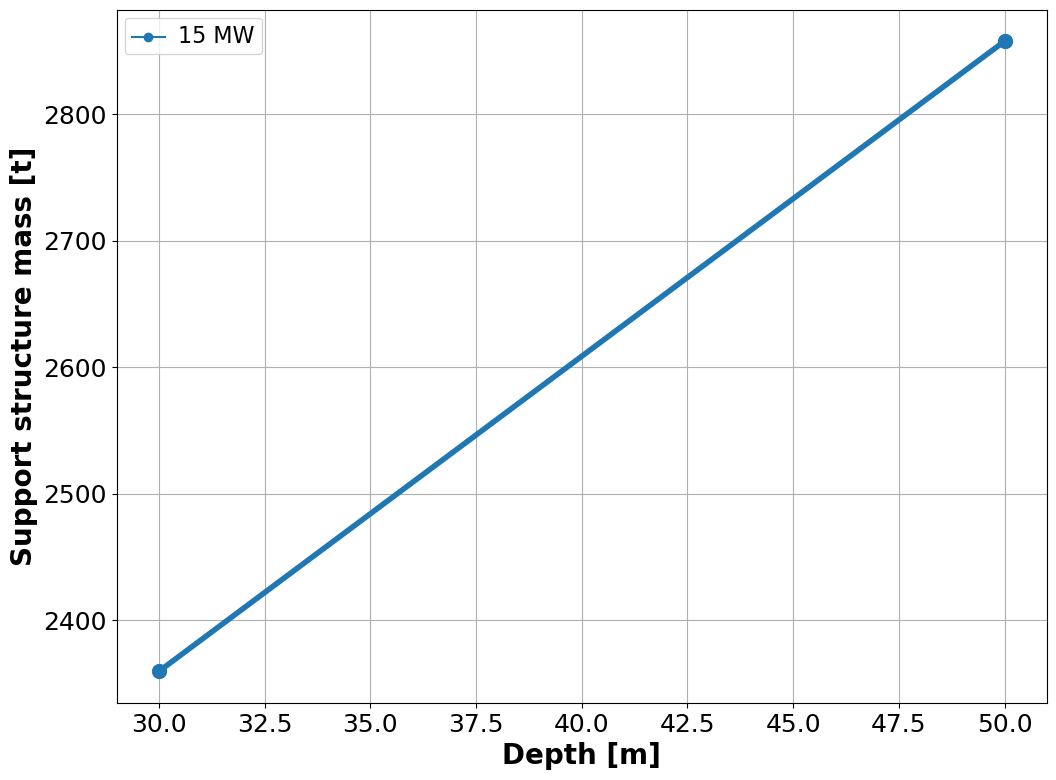

'/Users/nriccobo/GitHub/WISDEM/examples/99_tower_gbf'

In [263]:
# Create figures of design point trends for tower mass, monopile mass, combined mass
xstr = 'Depth [m]'
legstr = [f"{r} MW" for r in ratings] # ['15 MW','20 MW','22 MW','25 MW']
fig, ax = init_fig_axis()
ax.plot(depths, 1e-3*m_tow.T,'-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Tower mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{base}_cases-tower_mass_{name}")
                    )

fig, ax = init_fig_axis()
ax.plot(depths, 1e-3*m_mono.T, '-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Monopile mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{base}_cases-monopile_mass_{name}")
                    )

fig, ax = init_fig_axis()
# l_mono.T
ax.plot(depths, 1e-3*m_struct.T, '-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Support structure mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{base}_cases-structural_mass_{name}")
                    )
plt.show()

os.getcwd()

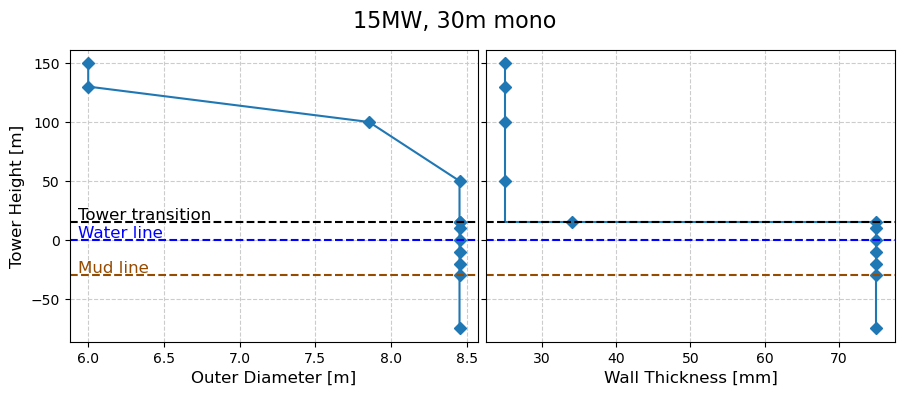

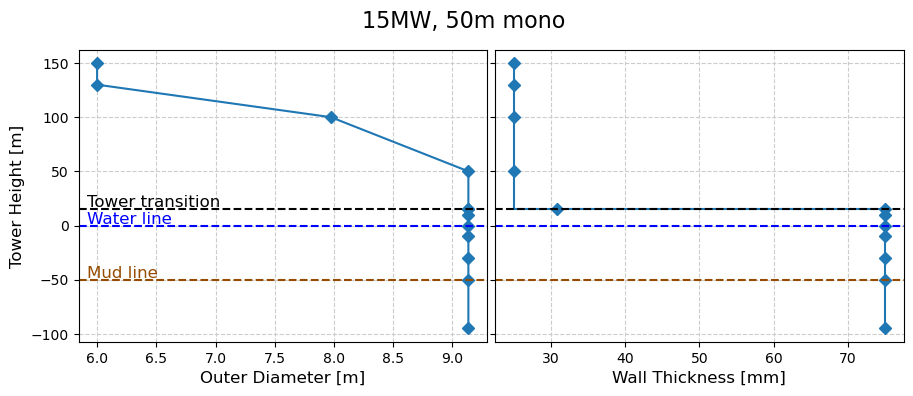

/Users/nriccobo/GitHub/WISDEM/examples/99_tower_gbf


In [264]:
# Tower geometry profiles by depth
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
brown = np.array([150.0, 75.0, 0.0]) / 256.0
for di, d in enumerate(depths):
    ftow = plt.figure(figsize=(11, 4))
    ftow.suptitle(f'{r}MW, {d}m {base}')
    ax1 = ftow.add_subplot(121)
    for ri, r in enumerate(ratings):

        ax1.plot(diam[r][d], zpts[r][d], '-', color=colors[ri], marker='D', label=f'{r} MW')
    vx = ax1.get_xlim()
    vy = ax1.get_ylim()
    zs = zpts[r][d]
    if zs.min() < -5.0:
        h_trans = out_archive['monopile.ref_axis_m'][-1,2]
        ax1.plot(vx, np.zeros(2), color="b", linestyle="--")
        ax1.plot(vx, -d * np.ones(2), color=brown, linestyle="--")
        ax1.plot(vx, h_trans * np.ones(2), color="k", linestyle="--")
        ax1.text(vx[0] + 0.02 * np.diff(vx), 2, "Water line", color="b", fontsize=12)
        ax1.text(vx[0] + 0.02 * np.diff(vx), -d + 2, "Mud line", color=brown, fontsize=12)
        ax1.text(vx[0] + 0.02 * np.diff(vx), h_trans + 2, "Tower transition", color="k", fontsize=12)
    ax1.set_xlim(vx)
    #ax1.set_ylim([vy[0], 25])
    plt.xlabel("Outer Diameter [m]")
    plt.ylabel("Tower Height [m]")
    plt.grid(color=[0.8, 0.8, 0.8], linestyle="--")

    ax2 = ftow.add_subplot(122)
    for ri, r in enumerate(ratings):
        ax2.step(1e3 * thick[r][d], zpts[r][d], '-', color=colors[ri], marker='D', label=f'{r} MW', where="post")
    vx = ax2.get_xlim()
    vy = ax2.get_ylim()
    if zs.min() < -5.0:
        ax2.plot(vx, np.zeros(2), color="b", linestyle="--")
        ax2.plot(vx, -d * np.ones(2), color=brown, linestyle="--")
        ax2.plot(vx, h_trans * np.ones(2), color="k", linestyle="--")
    ax2.set_xlim(vx)
    #ax2.set_ylim([vy[0], 25])
    plt.xlabel("Wall Thickness [mm]")
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.grid(color=[0.8, 0.8, 0.8], linestyle="--")
    plt.subplots_adjust(bottom=0.15, left=0.15)
    ftow.subplots_adjust(hspace=0.02, wspace=0.02, bottom=0.15, left=0.15)
    if save_plots: save(ftow,
                        os.path.join(FIGDIR, f'tower-{base}_depth{d}_{name}')) #, pad_inches=0.1, bbox_inches="tight")
plt.show()

print(os.getcwd())

In [265]:
# Track optimization convergance
all_data = []
for di, d in enumerate(depths):
    print(f"Depth: {d}")
    fom_path = os.path.join(ROOT, '15mw', f'{d}m', f'outputs_{base}', fom_name)

    print(f"fom: {fom_path}")
    cr = om.CaseReader(fom_path)
    case = cr.get_case(0)
    keys = case.outputs.keys()
    data_dict = {}
    for key in keys:
        data_dict[key] = []

    for _case in cr.get_cases('driver'):
        #_case = cr.get_case(case_id)
        for key in keys:
            data_dict[key].append(_case[key])

    data_df = pd.DataFrame.from_dict(data_dict)
    all_data.append(data_df)

#data_df.plot(subplots=True, layout=(3,3), figsize=(20,15))
for a in all_data:
    final_design = a.iloc[-1]
    print(f"length: {len(a)}")
    print(final_design)

Depth: 30
fom: /Users/nriccobo/GitHub/WISDEM/examples/99_tower_gbf/15mw/30m/outputs_mono/log_opt_mono_iea15.sql
Depth: 50
fom: /Users/nriccobo/GitHub/WISDEM/examples/99_tower_gbf/15mw/50m/outputs_mono/log_opt_mono_iea15.sql
length: 174
fixedse.structural_frequencies         [0.12999999996479222, 0.13053107491753993, 0.6...
fixedse.post.constr_global_buckling    [[0.09757569788093004], [0.21212543558941643],...
fixedse.post.constr_shell_buckling     [[0.06344621336217769], [0.0975147793985079], ...
fixedse.post.constr_stress             [[0.05945062819560962], [0.08375774434599313],...
fixedse.constr_d_to_t                  [112.69556151948272, 112.69556151947924, 112.6...
fixedse.slope                          [0.9999999999999031, 1.0000000000000342, 0.999...
fixedse.thickness_slope                [0.9999999999999998, 0.9999999999999994, 1.0, ...
fixedse.structural_mass                                              [2359499.454599135]
fixedse.constr_diam_consistency                     

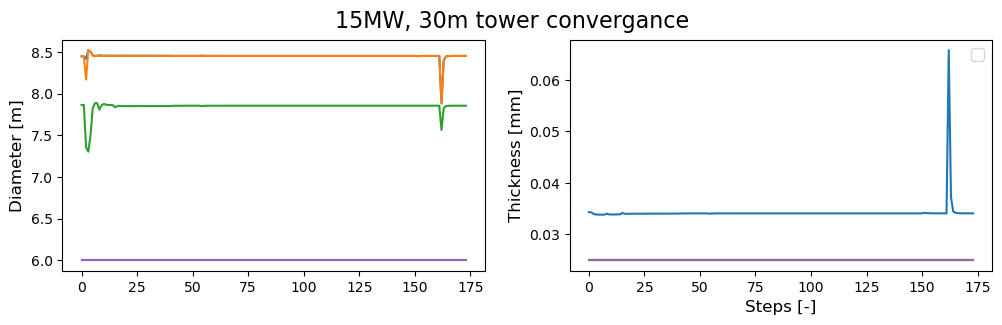

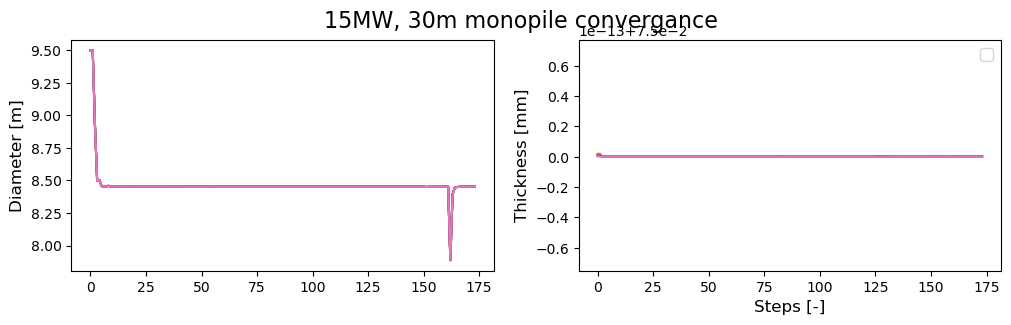

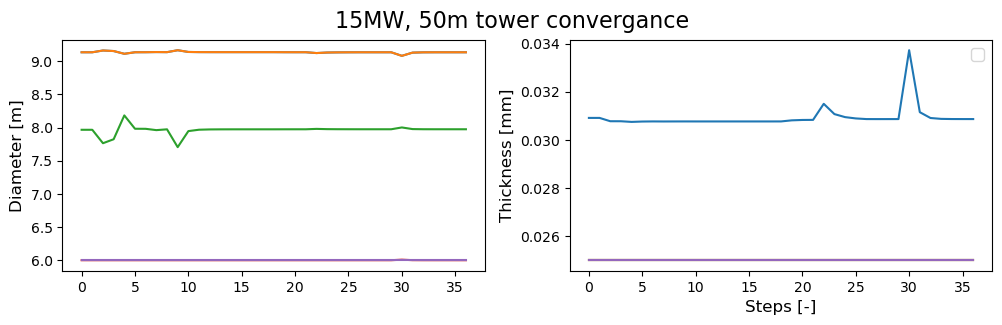

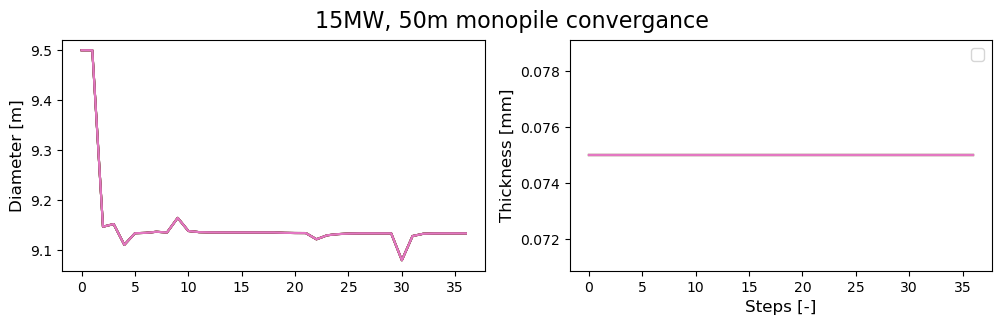

In [266]:
#print(len(data_df['monopile.layer_thickness']))
#print((data_df['monopile.layer_thickness'].iloc[0]).shape)
#print(data_df['monopile.layer_thickness'].head())

components = ['tower', 'monopile']

#print(pd.DataFrame(data_df['monopile.layer_thickness'].to_list()))
for a,d in zip(all_data, depths):
    for c in components:
        fig, ax = plt.subplots(1, len(components), figsize=(12,3), sharex=True)
        fig.suptitle(f"15MW, {d}m {c} convergance")
        d_temp = a[f'{c}.diameter']
        t_temp = a[f'{c}.layer_thickness']

        diam_mat = pd.DataFrame(d_temp.to_list())
        #print(diam_mat)
        for col in diam_mat.columns:
            ax[0].plot(diam_mat.index, diam_mat[col])

        layer_shape = t_temp.iloc[0].shape

        t_temp = t_temp.apply(lambda x: x.reshape(layer_shape[1]))

        thick_mat = pd.DataFrame(t_temp.to_list())
        #print(thick_mat)
        for col2 in thick_mat.columns:
            ax[1].plot(thick_mat.index, thick_mat[col2] ) #,label=f'z={round(zpts[15][20][ci],1)}')

        ax[0].set_ylabel("Diameter [m]")
        ax[1].set_ylabel("Thickness [mm]")
        ax[1].set_xlabel("Steps [-]")
        handles, labels = plt.gca().get_legend_handles_labels()
        ax[1].legend(handles[::-1], labels[::-1],loc='upper right')

        plt.show()

In [267]:
constraints = []

#print(final_design['towerse.post.constr_global_buckling']) # when only GB for tower
print(final_design['fixedse.post.constr_global_buckling']) # when only GB for monopile
#print(max(final_design['fixedse.post_monopile_tower.constr_global_buckling'])) # GB for monopile and tower

#print(final_design['fixedse.constr_taper'])

[[0.11890459]
 [0.25486612]
 [0.83531329]
 [0.9183685 ]
 [0.88543996]
 [0.85233919]
 [0.81904855]
 [0.78553816]
 [0.75176041]
 [0.73476455]
 [0.71767324]
 [0.70047019]
 [0.6836828 ]
 [0.66737456]
 [0.65107834]
 [0.64293818]
 [0.63480195]
 [0.6266699 ]]
